In [51]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import japanize_matplotlib
from scipy.linalg import expm
from scipy.stats import norm
from math import factorial
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
import pandas as pd
import tqdm
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import beta

pd.set_option("display.float_format", lambda x: f"{x:.7f}")
import japanize_matplotlib
from einsum_sympy import einsum_sympy
import sympy as sp
from sympy.tensor.array import derive_by_array

In [ ]:
import sympy as sp
from sympy import Array, symbols
from sympy.tensor.array import derive_by_array
from einsum_sympy import einsum_sympy
from dataclasses import dataclass
from sympy.utilities.lambdify import lambdify
import sympy as sp
from sympy import Array


@dataclass(frozen=True)
class Test:
    x: sp.Array
    y: sp.Array
    theta_1: sp.Array
    theta_2: sp.Array
    theta_3: sp.Array
    A: sp.Array
    B: sp.Array
    H: sp.Array

    # ---モデルの定義---
    def __post_init__(self):
        # C = B ⊗ B を immutable な形で設定
        object.__setattr__(self, "C", einsum_sympy("ij,kj->ik", self.B, self.B))
        # --- A_func, B_func, H_func の定義 ---
        # lambdify で使うために、sympy のシンボルを numpy の関数に変換
        object.__setattr__(
            self,
            "A_func",
            lambdify((self.x, self.y, self.theta_2), self.A, modules="numpy"),
        )
        object.__setattr__(
            self,
            "B_func",
            lambdify((self.x, self.y, self.theta_1), self.B, modules="numpy"),
        )
        object.__setattr__(
            self,
            "H_func",
            lambdify((self.x, self.y, self.theta_3), self.H, modules="numpy"),
        )
        object.__setattr__
        (self, "C_func", lambdify((self.x, self.y, self.theta_1), self.C, modules="numpy")),


        # --- bar_theta_1, bar_theta_2, bar_theta_3 の定義 ---
        def add_bar_prefix(theta_array, name_prefix):
            return sp.Array([sp.Symbol(f"bar_{str(s)}") for s in theta_array])

        object.__setattr__(self, "bar_theta_1", add_bar_prefix(self.theta_1, "theta1"))
        object.__setattr__(self, "bar_theta_2", add_bar_prefix(self.theta_2, "theta2"))
        object.__setattr__(self, "bar_theta_3", add_bar_prefix(self.theta_3, "theta3"))

        # --- L0_cache の初期化 ---
        # L0_cache は、L_0 の計算結果をキャッシュするための辞書
        object.__setattr__(self, "_L_cache", {})  # キャッシュ辞書
        object.__setattr__(self, "_L0_func_cache", {})  # キャッシュ辞書
        object.__setattr__(self, "_S_cache", {})  # キャッシュ辞書
        object.__setattr__(self, "_S_func_cache", {})  # キャッシュ辞書

    # ---シミュレーション関数の定義---
    def simulate(
        self,
        true_theta,
        t_max,
        h,
        burn_out,
        seed=42,
        x0=None,
        y0=None,
        dt=0.001,
    ):
        """
        Euler-Maruyama法によるシミュレーション

        Parameters:
        - true_theta: tuple of theta_1, theta_2, theta_3 values
        - t_max: 取り出す区間の長さ
        - h: 間引き後の出力のステップサイズ
        - burn_out: 捨てる初期時間（定常化まで）
        - dt: シミュレーションの刻み幅
        - x0, y0: 初期値ベクトル（Noneならゼロ初期値）

        Returns:
        - x_series, y_series: shape = (T, d_x), (T, d_y)
        """
        import numpy as np

        np.random.seed(seed)
        theta_1_val, theta_2_val, theta_3_val = true_theta
        total_steps = int((t_max + burn_out) / dt)
        d_x = self.x.shape[0]
        d_y = self.y.shape[0]
        r = self.B.shape[1]

        x_all = np.zeros((total_steps + 1, d_x))
        y_all = np.zeros((total_steps + 1, d_y))
        x_all[0] = x0 if x0 is not None else np.zeros(d_x)
        y_all[0] = y0 if y0 is not None else np.zeros(d_y)

        for t in range(total_steps):
            xt, yt = x_all[t], y_all[t]
            A_val = self.A_func(xt, yt, theta_2_val)
            B_val = self.B_func(xt, yt, theta_1_val)
            H_val = self.H_func(xt, yt, theta_3_val)

            dW = np.random.randn(r) * np.sqrt(dt)
            x_all[t + 1] = xt + A_val * dt + (B_val @ dW.reshape(-1, 1)).flatten()
            y_all[t + 1] = yt + H_val * dt

        # 間引き＆burn-out処理
        start_index = int(burn_out / dt)
        step_stride = int(h / dt)
        x_series = x_all[start_index::step_stride]
        y_series = y_all[start_index::step_stride]

        return x_series, y_series

    # ---疑似尤度関数の定義---

    # def L(self, f, k: int):
    #     """
    #     f: 作用素の引数
    #     """

    #     def L_once(f):
    #         # 作用素Lを定義
    #         # 1階微分を計算
    #         df_dx = derive_by_array(f, self.x)
    #         df_dy = derive_by_array(f, self.y)
    #         d2f_dx2 = derive_by_array(df_dx, self.x)

    #         # 作用素Lを適用
    #         return (
    #             einsum_sympy("i,ij->j", self.A, df_dx)
    #             + einsum_sympy("i,ij->j", self.H, df_dy)
    #             + (1 / 2) * einsum_sympy("ij,ijk->k", self.C, d2f_dx2)
    #         )

    #     # 作用素の次数に応じて、Lをk回適用する
    #     key = (f, k)  # or (str(f), k) でもOK
    #     if key in self._L_cache:
    #         return self._L_cache[key]
    #     elif k == 0:
    #         self._L_cache[key] = f
    #         return f
    #     else:
    #         result = f
    #         for _ in range(1, k + 1):
    #             if (f, _) in self._L_cache:
    #                 result = self._L_cache[(f, _)]
    #             else:
    #                 result = L_once(result)
    #                 self._L_cache[(f, _)] = result
    #         self._L_cache[key] = result
    #         return result

    def L_0(self, f, k: int):
        return self.L(f, k) / factorial(k)

    def L(self, f, k: int):
        """
        任意shapeのテンソルfにLをk回適用する。
        """

        def L_once(f_tensor):
            # 各要素に対してL演算をかける
            return f_tensor.applyfunc(lambda elem: self._L_elem_once(elem))

        def L_k(f_tensor, k):
            # Lをk回繰り返し適用（キャッシュ付き）
            key = (str(f_tensor), k)
            if key in self._L_cache:
                return self._L_cache[key]
            if k == 0:
                self._L_cache[key] = f_tensor
                return f_tensor

            result = f_tensor
            for i in range(1, k + 1):
                result = L_once(result)
                self._L_cache[(str(f_tensor), i)] = result

            self._L_cache[key] = result
            return result

        return L_k(f, k)

    def _L_elem_once(self, f_elem):
        """fの1つの成分に対してLを1回だけ適用"""
        df_dx = derive_by_array(f_elem, self.x)
        df_dy = derive_by_array(f_elem, self.y)
        d2f_dx2 = derive_by_array(df_dx, self.x)

        return (
            einsum_sympy("i,i->", self.A, df_dx)
            + einsum_sympy("i,i->", self.H, df_dy)
            + (1 / 2) * einsum_sympy("ij,ij->", self.C, d2f_dx2)
        )
    
    def L_0_func(self, f, k: int):
        if (k, f) in self._L0_func_cache:
            return self._L0_func_cache[(k, f)]
        else:
            lambdify_func = lambdify(
                (self.x, self.y, self.theta_1, self.theta_2, self.theta_3), self.L_0(f,k), modules="numpy"
            )
            self._L0_func_cache[(k, f)] = lambdify_func
            return lambdify_func
        

    def D_func(self,L0_x_funcs,L0_y_funcs,x_j,y_j,x_j_1,y_j_1,theta_2,theta_3,bar_theta_1,bar_theta_2,bar_theta_3,h,k:int):
        D_x = h**(-1/2) * (x_j - x_j_1)
        D_y = h**(-3/2) * (y_j - y_j_1)

        if k >= 1:
            # 1階の項
            D_x -= h**(-1/2) * h * self.A_func(x_j_1,y_j_1,theta_2)
            D_y -= h**(-3/2) * h * self.H_func(x_j_1,y_j_1,theta_3)
        if k >= 2:
            # 2階以上の項の合計
            for m in range(2, k+1):
                D_x -= h**(-1/2) * h**m * L0_x_funcs[m](x_j_1,y_j_1,bar_theta_1,bar_theta_2,bar_theta_3)
                D_y -= h**(-3/2) * h**m * L0_y_funcs[m](x_j_1,y_j_1,bar_theta_1,bar_theta_2,bar_theta_3)

            # k+1階の項（y成分だけ）
            D_y -= h**(-3/2) * h**(k+1) * L0_y_funcs[k+1](x_j_1,y_j_1,bar_theta_1,bar_theta_2,bar_theta_3)
        
        return D_x,D_y

    
    # def D(self, x_j, y_j, x_j_1, y_j_1, h, k: int):
    #     subs_dict = dict(zip(self.x, x_j_1)) | dict(zip(self.y, y_j_1))
    #     subs_dict_ = (
    #         subs_dict
    #         | dict(zip(self.theta_1, self.bar_theta_1))
    #         | dict(zip(self.theta_2, self.bar_theta_2))
    #         | dict(zip(self.theta_3, self.bar_theta_3))
    #     )

    #     D_x = sp.Array(h ** (-1 / 2) * (x_j - x_j_1))
    #     D_y = sp.Array(h ** (-1 / 3) * (y_j - y_j_1))

    #     if k >= 1:
    #         # 1階の項
    #         D_x -= h ** (-1 / 2) * h * self.L_0(self.x, 1).subs(subs_dict)
    #         D_y -= h ** (-1 / 3) * h * self.L_0(self.y, 1).subs(subs_dict)

    #     if k >= 2:
    #         # 2階以上の項の合計
    #         for m in range(2, k + 1):
    #             D_x -= h ** (-1 / 2) * h**m * self.L_0(self.x, m).subs(subs_dict_)
    #             D_y -= h ** (-1 / 3) * h**m * self.L_0(self.y, m).subs(subs_dict_)

    #         # k+1階の項（y成分だけ）
    #         D_y -= (
    #             h ** (-1 / 3) * h ** (k + 1) * self.L_0(self.y, k + 1).subs(subs_dict_)
    #         )

    #     return D_x, D_y

    def S(self, k: int):

        def compute_T(l):
            T_xx = self.L_0(sp.tensorproduct(self.x, self.x), l + 1)
            T_xy = self.L_0(sp.tensorproduct(self.x, self.y), l + 2)
            T_yx = self.L_0(sp.tensorproduct(self.y, self.x), l + 2)
            T_yy = self.L_0(sp.tensorproduct(self.y, self.y), l + 3)
            return T_xx, T_xy, T_yx, T_yy

        def compute_U(l):
            def sum_tensor(f1, f2, total_order):
                result = sp.Array(np.zeros((f1.shape[0], f2.shape[0])))
                for m1 in range(total_order + 1):
                    m2 = total_order - m1
                    term = einsum_sympy("i,j->ij", self.L_0(f1, m1), self.L_0(f2, m2))
                    result += term
                return result

            U_xx = sum_tensor(self.x, self.x, l + 1)
            U_xy = sum_tensor(self.x, self.y, l + 2)
            U_yx = sum_tensor(self.y, self.x, l + 2)
            U_yy = sum_tensor(self.y, self.y, l + 3)
            return U_xx, U_xy, U_yx, U_yy

        T_xx, T_xy, T_yx, T_yy = compute_T(k)
        U_xx, U_xy, U_yx, U_yy = compute_U(k)
        S_xx, S_xy, S_yx, S_yy = T_xx - U_xx, T_xy - U_xy, T_yx - U_yx, T_yy - U_yy

        return S_xx, S_xy, S_yx, S_yy

    def S_func(self,k):
        if k in self._S_func_cache:
            return self._S_func_cache[k]
        else:
            S_xx,S_xy,S_yx,S_yy = self.S(k)
            S_xx_func = lambdify((self.x, self.y, self.theta_1, self.theta_2, self.theta_3),S_xx)
            S_xy_func = lambdify((self.x, self.y, self.theta_1, self.theta_2, self.theta_3),S_xy) 
            S_yx_func = lambdify((self.x, self.y, self.theta_1, self.theta_2, self.theta_3),S_yx)
            S_yy_func = lambdify((self.x, self.y, self.theta_1, self.theta_2, self.theta_3),S_yy)
            self._S_func_cache[k] = (S_xx_func, S_xy_func, S_yx_func, S_yy_func)
            return S_xx_func,S_xy_func,S_yx_func,S_yy_func

    def Quasilikelihood_1_(self, x_series, y_series, h, k):
        """
        疑似尤度関数の計算

        Parameters:
        - x_series: xの時系列データ
        - y_series: yの時系列データ
        - h: ステップサイズ
        - k: 順序

        Returns:
        - 疑似尤度関数の値
        """
        n = x_series.shape[0]
        inv_C = sp.Array(sp.Matrix(self.C).inv())
        inv_C_func = lambdify(
            (self.x, self.y, self.theta_1),
            inv_C,
            modules="numpy",
        )
        log_det_C = sp.log(sp.det(sp.Matrix(self.C)))
        log_det_C_func = lambdify(
            (self.x, self.y, self.theta_1),
            log_det_C,
            modules="numpy",
        )

        def Quasilikelihood_1_val(theta_1,bar_theta_1,bar_theta_2,bar_theta_3):
            # 疑似尤度関数の計算
            result = 0
            L0_x_funcs = {m: self.L_0_func(self.x, m) for m in range(k)}
            L0_y_funcs = {m: self.L_0_func(self.y, m) for m in range(k+1)}
            for j in range(1,n):
                x_j = x_series[j]
                y_j = y_series[j]
                x_j_1 = x_series[j - 1]
                y_j_1 = y_series[j - 1]
                inv_C_j_1 = inv_C_func(x_j_1, y_j_1, theta_1)
                log_det_C_j_1 = log_det_C_func(x_j_1, y_j_1, theta_1)
                D_x_j_1, D_y_j_1 = self.D_func(L0_x_funcs,L0_y_funcs,x_j, y_j, x_j_1, y_j_1,bar_theta_2,bar_theta_3,bar_theta_1,bar_theta_2,bar_theta_3, h, k - 1)
                d_x = self.x.shape[0]
                sum_S_xx = np.zeros((d_x, d_x))
                # print("sum_S_xx",sum_S_xx.shape)

                if k >= 2:
                    for l in range(1, k):
                        S_l_xx_func = self.S_func(l)[0]
                        S_l_xx_val = S_l_xx_func(x_j_1, y_j_1, theta_1, bar_theta_2, bar_theta_3)
                        sum_S_xx += h**l * S_l_xx_val

                val =  - np.einsum("ij,i,j->", inv_C_j_1, D_x_j_1,D_x_j_1) - np.einsum("ij,ij->" , inv_C_j_1,sum_S_xx) - log_det_C_j_1
                result += val/(2*n)
            return result
        return Quasilikelihood_1_val


        # 疑似尤度関数の計算
        # result = sp.Array(0)
        # for j in range(1, n):
        #     x_j = x_series[j]
        #     y_j = y_series[j]
        #     x_j_1 = x_series[j - 1]
        #     y_j_1 = y_series[j - 1]
        #     C_j_1 = self.C.subs(dict(zip(self.x, x_j_1)))
        #     inv_C_j_1 = sp.Array(sp.Matrix(C_j_1).inv())
        #     log_det_C_j_1 = sp.log(sp.det(sp.Matrix(C_j_1)))

        #     D_x, D_y = self.D(x_j, y_j, x_j_1, y_j_1, h, k - 1)
        #     sum_S_xx = sp.Array(np.zeros_like(sp.tensorproduct(self.x, self.x)))

        #     if k >= 2:
        #         for l in range(1, k):
        #             S_l_xx = self.S(x_j_1, y_j_1, l)[0]
        #             sum_S_xx += h**l * S_l_xx

        #     val = einsum_sympy(
        #         "ij,ij->", inv_C_j_1, sp.tensorproduct(D_x, D_x) - sum_S_xx
        #     )
        #     log_det_C_j_1 = sp.Array(log_det_C_j_1)
        #     result -= (val + log_det_C_j_1) / (2 * n)

        # return result

    # def quasilikelihood_1(self, x_series, y_series, h, k):
    #     n = x_series.shape[0]

    #     def substitute_variables(f, x_j, y_j, x_j_1, y_j_1):
    #         subs_j = dict(zip(self.x, x_j)) | dict(zip(self.y, y_j))
    #         return f.subs(subs_j)

    #     for j in range(1, n):
    #         x_j = x_series[j]
    #         y_j = y_series[j]
    #         x_j_1 = x_series[j - 1]
    #         y_j_1 = y_series[j - 1]

In [188]:
import sympy as sp
from sympy import Array, symbols, factorial, tensorproduct, log, det, Matrix
from sympy.tensor.array import derive_by_array
from einsum_sympy import einsum_sympy
from dataclasses import dataclass
from sympy.utilities.lambdify import lambdify
import numpy as np
# For profiling (optional)
# import cProfile


@dataclass(frozen=True)
class Test:
    """
    多次元の拡散過程と観測過程を扱うためのクラス。

    記号計算 (sympy) を用いてモデルを定義し、
    数値計算 (numpy) のための関数を lambdify で生成する。
    Euler-Maruyama法によるシミュレーション、
    および疑似尤度関数の計算機能を提供する。

    Attributes:
        x (sp.Array): 状態変数 (sympyシンボル配列, shape=(d_x,))
        y (sp.Array): 観測変数 (sympyシンボル配列, shape=(d_y,))
        theta_1 (sp.Array): パラメータ1 (sympyシンボル配列)
        theta_2 (sp.Array): パラメータ2 (sympyシンボル配列)
        theta_3 (sp.Array): パラメータ3 (sympyシンボル配列)
        A (sp.Array): ドリフト項の x 成分 (sympy式配列, shape=(d_x,))
        B (sp.Array): 拡散項 (sympy式配列, shape=(d_x, r))
        H (sp.Array): 観測過程のドリフト項 (sympy式配列, shape=(d_y,))
        # --- 以下は __post_init__ で自動生成 ---
        # C (sp.Array): B @ B.T (shape=(d_x, d_x))
        # A_func, B_func, H_func, C_func: 対応する numpy 関数
        # inv_C_func, log_det_C_func: C の逆行列と対数行列式の numpy 関数
        # bar_theta_1, bar_theta_2, bar_theta_3: 'bar_' プレフィックス付きパラメータシンボル
        # _L_cache, _L0_func_cache, _S_cache, _S_func_cache: 計算結果キャッシュ用辞書
    """
    x: sp.Array
    y: sp.Array
    theta_1: sp.Array
    theta_2: sp.Array
    theta_3: sp.Array
    A: sp.Array
    B: sp.Array
    H: sp.Array

    @staticmethod
    def _add_bar_prefix(theta_array):
        """Helper function to create symbols with 'bar_' prefix."""
        return sp.Array([sp.Symbol(f"bar_{str(s)}") for s in theta_array])

    def __post_init__(self):
        """
        初期化後の設定処理。
        派生的な属性の計算、lambdifyによる関数生成、キャッシュの初期化を行う。
        frozen=True のため、属性設定には object.__setattr__ を使用する。
        """
        # Use object.__setattr__ because the dataclass is frozen
        # --- 派生的な記号計算 ---
        # C = B @ B.T (テンソル積として計算)
        try:
            C_expr = einsum_sympy("ik,jk->ij", self.B, self.B)
            object.__setattr__(self, "C", C_expr)
        except Exception as e:
            print(f"Error calculating C = B @ B.T: {e}")
            raise

        # --- lambdify による数値計算用関数の生成 ---
        common_args = (self.x, self.y)
        try:
            object.__setattr__(self, "A_func", lambdify((*common_args, self.theta_2), self.A, modules="numpy"))
            object.__setattr__(self, "B_func", lambdify((*common_args, self.theta_1), self.B, modules="numpy"))
            object.__setattr__(self, "H_func", lambdify((*common_args, self.theta_3), self.H, modules="numpy"))
            object.__setattr__(self, "C_func", lambdify((*common_args, self.theta_1), self.C, modules="numpy"))

            # --- inv(C) と log(det(C)) の関数も事前に生成 ---
            C_matrix = Matrix(self.C)
            inv_C_expr = sp.Array(C_matrix.inv())
            log_det_C_expr = log(C_matrix.det())
            # Optional: Simplify before lambdify (can be slow)
            # inv_C_expr = sp.simplify(inv_C_expr)
            # log_det_C_expr = sp.simplify(log_det_C_expr)
            object.__setattr__(self, "inv_C_func", lambdify((*common_args, self.theta_1), inv_C_expr, modules="numpy"))
            object.__setattr__(self, "log_det_C_func", lambdify((*common_args, self.theta_1), log_det_C_expr, modules="numpy"))

        except Exception as e:
            print(f"Error during lambdification in __post_init__: {e}")
            raise

        # --- 'bar_' プレフィックス付きシンボルの生成 ---
        object.__setattr__(self, "bar_theta_1", self._add_bar_prefix(self.theta_1))
        object.__setattr__(self, "bar_theta_2", self._add_bar_prefix(self.theta_2))
        object.__setattr__(self, "bar_theta_3", self._add_bar_prefix(self.theta_3))

        # --- キャッシュ用辞書の初期化 ---
        object.__setattr__(self, "_L_cache", {})      # L(f, k) の結果キャッシュ
        object.__setattr__(self, "_L0_func_cache", {}) # lambdify(L_0(f, k)) の結果キャッシュ
        # object.__setattr__(self, "_S_cache", {})      # S(k) の結果キャッシュ (記号計算)
        object.__setattr__(self, "_S_func_cache", {}) # lambdify(S(k)) の結果キャッシュ

    # --- シミュレーション関数 ---
    def simulate(
        self,
        true_theta,
        t_max,
        h,
        burn_out,
        seed=42,
        x0=None,
        y0=None,
        dt=0.001,
    ):
        """
        Euler-Maruyama法を用いて状態変数 x と観測変数 y の時系列データを生成する。

        Parameters:
            true_theta (tuple): (theta_1_val, theta_2_val, theta_3_val) の真値。
            t_max (float): 生成する時系列データの期間長（burn_out期間を除く）。
            h (float): 生成されるデータの時間ステップ幅（間引き後）。
            burn_out (float): 定常状態に達するまで捨てる初期期間。
            seed (int): 乱数生成器のシード値。
            x0 (np.ndarray, optional): x の初期値ベクトル。None の場合はゼロベクトル。
            y0 (np.ndarray, optional): y の初期値ベクトル。None の場合はゼロベクトル。
            dt (float): シミュレーション内部の微小時間ステップ幅。

        Returns:
            tuple[np.ndarray, np.ndarray]: (x_series, y_series)
                x_series: x の時系列データ (shape=(T, d_x))
                y_series: y の時系列データ (shape=(T, d_y))
                ここで T は t_max / h に近い整数
        """
        np.random.seed(seed)
        theta_1_val, theta_2_val, theta_3_val = true_theta
        total_steps = int((t_max + burn_out) / dt)
        d_x = self.x.shape[0]
        d_y = self.y.shape[0]
        r = self.B.shape[1] # Number of Wiener processes

        x_all = np.zeros((total_steps + 1, d_x))
        y_all = np.zeros((total_steps + 1, d_y))
        x_all[0] = x0 if x0 is not None else np.zeros(d_x)
        y_all[0] = y0 if y0 is not None else np.zeros(d_y)

        # Pre-fetch functions for the loop
        A_func_local = self.A_func
        B_func_local = self.B_func
        H_func_local = self.H_func

        for t in range(total_steps):
            xt, yt = x_all[t], y_all[t]
            try:
                A_val = A_func_local(xt, yt, theta_2_val)
                B_val = B_func_local(xt, yt, theta_1_val)
                H_val = H_func_local(xt, yt, theta_3_val)
            except Exception as e:
                print(f"Error evaluating A, B, or H function at step {t}: {e}")
                print(f"xt={xt}, yt={yt}, theta_1={theta_1_val}, theta_2={theta_2_val}, theta_3={theta_3_val}")
                raise

            dW = np.random.randn(r) * np.sqrt(dt)
            # Ensure B_val @ dW results in a flat array of size d_x
            diffusion_term = (B_val @ dW.reshape(-1, 1)).flatten()
            if diffusion_term.shape[0] != d_x:
                 raise ValueError(f"Shape mismatch in diffusion term: expected ({d_x},), got {diffusion_term.shape}")

            x_all[t + 1] = xt + A_val * dt + diffusion_term
            y_all[t + 1] = yt + H_val * dt

        # Apply burn-out and thinning
        start_index = int(burn_out / dt)
        step_stride = int(h / dt)
        if step_stride <= 0:
             raise ValueError("Step stride 'h' must be positive and typically >= 'dt'")

        x_series = x_all[start_index::step_stride]
        y_series = y_all[start_index::step_stride]

        return x_series, y_series

    # --- Infinitesimal Generator L ---

    def _L_elem_once(self, f_elem):
        """
        スカラー関数 f_elem に対して infinitesimal generator L を1回適用する。
        L(f) = (A * grad_x(f)) + (H * grad_y(f)) + 0.5 * Tr(C * Hess_x(f))
        """

        f_elem = sp.sympify(f_elem)  # Ensure f_elem is a sympy expression

        try:
            df_dx = derive_by_array(f_elem, self.x)
            df_dy = derive_by_array(f_elem, self.y)
            # d2f_dx2 is the Hessian matrix w.r.t. x
            d2f_dx2 = derive_by_array(df_dx, self.x)

            # Ensure dimensions match for einsum
            # Term 1: A (d_x) dot df_dx (d_x) -> scalar
            term1 = einsum_sympy("i,i->", self.A, df_dx)
            # Term 2: H (d_y) dot df_dy (d_y) -> scalar
            term2 = einsum_sympy("i,i->", self.H, df_dy)
            # Term 3: 0.5 * Trace(C (d_x, d_x) @ d2f_dx2 (d_x, d_x))
            # einsum calculates element-wise product and sums: sum_{i,j} C[i,j] * d2f_dx2[i,j]
            term3 = (sp.S(1)/2) * einsum_sympy("ij,ij->", self.C, d2f_dx2)

            return term1 + term2 + term3
        except Exception as e:
            print(f"Error applying _L_elem_once to: {f_elem}")
            print(f"Error details: {e}")
            raise

    def L(self, f_tensor:sp.Array, k: int):
        """
        任意の形状を持つ sympy テンソル f_tensor の各要素に
        infinitesimal generator L を k 回適用する（キャッシュ利用）。

        Parameters:
            f_tensor (sp.Array): Lを適用する対象のシンボリックテンソル。
            k (int): L を適用する回数。

        Returns:
            sp.Array: L^k(f_tensor) の結果。
        """
        # Use a string representation of the tensor structure and k for caching
        # Note: This assumes str(tensor) is a reliable identifier.
        cache_key = (str(f_tensor), k)
        if cache_key in self._L_cache:
            return self._L_cache[cache_key]

        if k == 0:
            self._L_cache[cache_key] = f_tensor
            return f_tensor
        if k < 0:
            raise ValueError("Order k must be non-negative")

        # Recursively compute L^k(f) = L(L^{k-1}(f))
        # Get L^{k-1}(f) from cache or compute it
        f_prev = self.L(f_tensor, k - 1)

        # Apply L once to f_prev element-wise
        # Need to handle potential non-Expr elements if f_prev contains numbers
        try:
            result = f_prev.applyfunc(self._L_elem_once)
        except Exception as e:
             print(f"Error in L applying L once to L^{k-1}(f) for k={k}")
             print(f"L^{k-1}(f) = {f_prev}")
             print(f"Error details: {e}")
             raise

        self._L_cache[cache_key] = result
        return result

    def L_0(self, f_tensor, k: int):
        """
        L^k(f_tensor) / k! を計算する。
        """
        if k < 0:
            raise ValueError("Order k must be non-negative")
        Lk_f = self.L(f_tensor, k)
        # Use sp.Integer for exact division if possible
        denom = factorial(k)
        if denom == 0: # Should only happen for k < 0, but safety check
             raise ValueError("Factorial(k) is zero or invalid")
        # Apply division element-wise
        try:
             # Use sp.S(1)/denom for symbolic division
             result = Lk_f * (sp.S(1) / denom)
             # Alternatively, if you expect integer results:
             # result = Lk_f.applyfunc(lambda elem: elem / denom if isinstance(elem, sp.Basic) else elem)
        except Exception as e:
             print(f"Error calculating L_0 for k={k}: dividing by factorial({k})")
             print(f"L^k(f) = {Lk_f}")
             print(f"Error details: {e}")
             raise
        return result


    def L_0_func(self, f_tensor, k: int):
        """
        L_0(f_tensor, k) を計算し、その結果を lambdify して返す（キャッシュ利用）。

        Parameters:
            f_tensor (sp.Array): L_0 を適用する対象のシンボリックテンソル。
            k (int): L_0 の階数。

        Returns:
            callable: L_0(f, k) を数値計算する関数。
                      引数: (x_val, y_val, theta_1_val, theta_2_val, theta_3_val)
        """
        # Use (k, str(f_tensor)) as key, similar to L cache
        cache_key = (k, str(f_tensor))
        if cache_key in self._L0_func_cache:
            return self._L0_func_cache[cache_key]
        else:
            try:
                # Calculate the symbolic L_0 expression
                L0_expr = self.L_0(f_tensor, k)

                # Optional: Simplify before lambdify (can be slow)
                # L0_expr_simplified = sp.simplify(L0_expr)
                # lambdify_func = lambdify(
                #     (self.x, self.y, self.theta_1, self.theta_2, self.theta_3),
                #     L0_expr_simplified,
                #     modules="numpy"
                # )

                # Lambdify the expression
                lambdify_func = lambdify(
                    (self.x, self.y, self.theta_1, self.theta_2, self.theta_3),
                    L0_expr,
                    modules="numpy"
                )
                self._L0_func_cache[cache_key] = lambdify_func
                return lambdify_func
            except Exception as e:
                 print(f"Error creating L_0_func for k={k}, f={f_tensor}: {e}")
                 raise

    # --- Auxiliary functions for Quasi-Likelihood ---

    def D_func(self, L0_x_funcs, L0_y_funcs, x_j, y_j, x_j_1, y_j_1,
               theta_1_bar, theta_2_bar, theta_3_bar, h, k: int):
        """
        疑似尤度計算に必要な差分項 D_x, D_y を数値的に計算する。
        (D = Z_{j} - E[Z_j | F_{j-1}] のスケーリングされたバージョン, Z=(X,Y))

        Parameters:
            L0_x_funcs (dict): {m: lambdify(L_0(x, m))} の形式の辞書 (m=0 to k).
            L0_y_funcs (dict): {m: lambdify(L_0(y, m))} の形式の辞書 (m=0 to k+1).
            x_j, y_j (np.ndarray): 時刻 j でのデータ。
            x_j_1, y_j_1 (np.ndarray): 時刻 j-1 でのデータ。
            theta_1_bar, theta_2_bar, theta_3_bar (np.ndarray): バー付きパラメータの数値。
            h (float): 時間ステップ幅。
            k (int): 展開の次数。

        Returns:
            tuple[np.ndarray, np.ndarray]: (D_x, D_y)
        """
        # Define scaling factors for clarity
        # Use np.power for numerical calculation
        DX_SCALE = np.power(h, -0.5) if h > 0 else 0 # Avoid division by zero or complex numbers if h<=0
        # NOTE: The exponent for DY_SCALE was changed to -3.0/2.0 based on user input.
        # The theoretical scaling might be different (e.g., -1.0/3.0). Verify the formula.
        DY_SCALE = np.power(h, -3.0/2.0) if h > 0 else 0

        # Initial difference (scaled)
        D_x = DX_SCALE * (x_j - x_j_1)
        D_y = DY_SCALE * (y_j - y_j_1)

        # Note: L0_x_funcs[0] is L_0(x, 0) = x, L0_y_funcs[0] = y
        # Note: L0_x_funcs[1] is L_0(x, 1) = L(x), L0_y_funcs[1] = L(y)

        # Subtract Taylor expansion terms
        # All L0 functions take (x, y, theta1, theta2, theta3) as input
        common_args = (x_j_1, y_j_1, theta_1_bar, theta_2_bar, theta_3_bar)

        for m in range(1, k + 1):
             h_m = np.power(h, m)
             try:
                 L0_x_m_val = L0_x_funcs[m](*common_args)
                 L0_y_m_val = L0_y_funcs[m](*common_args)
             except KeyError as e:
                 print(f"Error: L0 function for order m={m} not found in provided dictionaries. Required up to k={k} for x, k+1 for y.")
                 raise e
             except Exception as e:
                 print(f"Error evaluating L0 function for m={m} at ({x_j_1}, {y_j_1}) with bar_thetas")
                 print(f"Error details: {e}")
                 raise

             D_x -= DX_SCALE * h_m * L0_x_m_val
             D_y -= DY_SCALE * h_m * L0_y_m_val

        # Add the final term for D_y (order k+1)
        try:
             h_k_plus_1 = np.power(h, k + 1)
             L0_y_k1_val = L0_y_funcs[k + 1](*common_args)
             D_y -= DY_SCALE * h_k_plus_1 * L0_y_k1_val
        except KeyError as e:
             print(f"Error: L0_y function for order m={k+1} not found.")
             raise e
        except Exception as e:
             print(f"Error evaluating L0_y function for m={k+1}")
             print(f"Error details: {e}")
             raise

        return D_x, D_y


    def S(self, k: int):
        """
        疑似尤度計算に必要な補正項 S = T - U を記号的に計算する。
        S_xx, S_xy, S_yx, S_yy を含むタプルを返す。

        T_{f1,f2}(l) = L_0(f1 * f2, l + n), n depends on f1, f2 scaling
        U_{f1,f2}(l) = Sum_{m1+m2=l+n} L_0(f1, m1) * L_0(f2, m2)

        Parameters:
            k (int): S_l を計算する際の次数 l (S(k) は S_l を計算)。

        Returns:
            tuple[sp.Array, sp.Array, sp.Array, sp.Array]:
                (S_xx, S_xy, S_yx, S_yy) のシンボリックテンソル。
                S_xx = T_xx - U_xx, etc.
        """
        # --- Helper function to compute T terms ---
        def compute_T(l):
            # T_xx = L0(x*x, l+1) -> shape (d_x, d_x)
            T_xx = self.L_0(tensorproduct(self.x, self.x), l + 1)
            # T_xy = L0(x*y, l+2) -> shape (d_x, d_y)
            T_xy = self.L_0(tensorproduct(self.x, self.y), l + 2)
            # T_yx = L0(y*x, l+2) -> shape (d_y, d_x)
            T_yx = self.L_0(tensorproduct(self.y, self.x), l + 2)
            # T_yy = L0(y*y, l+3) -> shape (d_y, d_y)
            T_yy = self.L_0(tensorproduct(self.y, self.y), l + 3)
            return T_xx, T_xy, T_yx, T_yy

        # --- Helper function to compute U terms ---
        def compute_U(l):
            # Helper for U calculation: Sum_{m1+m2=total_order} L0(f1,m1) * L0(f2,m2)
            def sum_tensor_product(f1, f2, total_order):
                 # Initialize result tensor with zeros, matching shape f1.shape x f2.shape
                 # Need to ensure f1, f2 are vectors (rank 1 tensors)
                 if f1.rank() != 1 or f2.rank() != 1:
                     raise ValueError("sum_tensor_product expects rank-1 tensors f1, f2")
                 # Create zero array symbolically
                 zero_elem = sp.S(0)
                 result_shape = (f1.shape[0], f2.shape[0])
                 # Create mutable sympy Matrix first, then convert to Array if needed
                 # Using MutableDenseNDimArray requires explicit zeros for the shape
                 result_matrix = sp.MutableDenseNDimArray([zero_elem] * np.prod(result_shape), result_shape)


                 for m1 in range(total_order + 1):
                     m2 = total_order - m1
                     if m2 < 0: continue # Should not happen with range up to total_order

                     try:
                        L0_f1_m1 = self.L_0(f1, m1) # shape (d_f1,)
                        L0_f2_m2 = self.L_0(f2, m2) # shape (d_f2,)

                        # Outer product: (d_f1,) x (d_f2,) -> (d_f1, d_f2)
                        term = tensorproduct(L0_f1_m1, L0_f2_m2)
                        # Ensure term has the correct shape before adding
                        if term.shape != result_shape:
                             # Attempt reshape if possible (e.g., scalar result)
                             if np.prod(term.shape) == np.prod(result_shape):
                                 term = sp.Array(term).reshape(*result_shape)
                             else:
                                 raise ValueError(f"Shape mismatch in sum_tensor_product: result {result_shape}, term {term.shape}")

                        result_matrix = result_matrix + term # Use element-wise addition
                     except Exception as e:
                         print(f"Error in sum_tensor_product for m1={m1}, m2={m2}, total={total_order}")
                         print(f"f1={f1}, f2={f2}")
                         print(f"L0_f1_m1 shape: {getattr(L0_f1_m1, 'shape', 'N/A')}")
                         print(f"L0_f2_m2 shape: {getattr(L0_f2_m2, 'shape', 'N/A')}")
                         print(f"term shape: {getattr(term, 'shape', 'N/A')}")
                         print(f"Error details: {e}")
                         raise
                 # Convert back to immutable Array
                 return sp.Array(result_matrix)

            U_xx = sum_tensor_product(self.x, self.x, l + 1)
            U_xy = sum_tensor_product(self.x, self.y, l + 2)
            U_yx = sum_tensor_product(self.y, self.x, l + 2)
            U_yy = sum_tensor_product(self.y, self.y, l + 3)
            return U_xx, U_xy, U_yx, U_yy

        # --- Compute T and U for the given order k ---
        try:
            T_xx, T_xy, T_yx, T_yy = compute_T(k)
            U_xx, U_xy, U_yx, U_yy = compute_U(k)
        except Exception as e:
            print(f"Error computing T or U components for S(k={k})")
            print(f"Error details: {e}")
            raise

        # --- Compute S = T - U ---
        # Ensure subtraction works element-wise for arrays
        S_xx = sp.Array(T_xx) - sp.Array(U_xx)
        S_xy = sp.Array(T_xy) - sp.Array(U_xy)
        S_yx = sp.Array(T_yx) - sp.Array(U_yx)
        S_yy = sp.Array(T_yy) - sp.Array(U_yy)

        result = (S_xx, S_xy, S_yx, S_yy)
        return result

    def S_func(self, k):
        """
        S(k) を計算し、その結果 (S_xx, S_xy, S_yx, S_yy) を lambdify して返す（キャッシュ利用）。

        Parameters:
            k (int): S の次数。

        Returns:
            tuple[callable, callable, callable, callable]:
                (S_xx_func, S_xy_func, S_yx_func, S_yy_func)
                各関数は引数 (x, y, theta_1, theta_2, theta_3) を取る。
        """
        cache_key = k
        if cache_key in self._S_func_cache:
            return self._S_func_cache[cache_key]
        else:
            try:
                # Calculate symbolic S terms
                S_xx, S_xy, S_yx, S_yy = self.S(k)

                # Optional: Simplify before lambdify (can be slow)
                # S_xx_s, S_xy_s, S_yx_s, S_yy_s = map(sp.simplify, (S_xx, S_xy, S_yx, S_yy))
                # args = (self.x, self.y, self.theta_1, self.theta_2, self.theta_3)
                # S_xx_func = lambdify(args, S_xx_s, modules="numpy")
                # S_xy_func = lambdify(args, S_xy_s, modules="numpy")
                # S_yx_func = lambdify(args, S_yx_s, modules="numpy")
                # S_yy_func = lambdify(args, S_yy_s, modules="numpy")

                # Lambdify each component
                args = (self.x, self.y, self.theta_1, self.theta_2, self.theta_3)
                S_xx_func = lambdify(args, S_xx, modules="numpy")
                S_xy_func = lambdify(args, S_xy, modules="numpy")
                S_yx_func = lambdify(args, S_yx, modules="numpy")
                S_yy_func = lambdify(args, S_yy, modules="numpy")

                result_funcs = (S_xx_func, S_xy_func, S_yx_func, S_yy_func)
                self._S_func_cache[cache_key] = result_funcs
                return result_funcs
            except Exception as e:
                 print(f"Error creating S_func for k={k}: {e}")
                 raise


    # --- Quasi-Likelihood Function ---

    def make_quasi_likelihood_v1_prime_evaluator(self, x_series, y_series, h, k):
        """
        与えられた時系列データに対する疑似尤度 V^{1'} を計算する関数（Evaluator）を返す。
        (Returns an evaluator function for the V^{1'} quasi-likelihood.)
        この実装は尤度の第1主要項（主に x に関連する項）を計算する。

        Parameters:
            x_series (np.ndarray): x の時系列データ (shape=(n, d_x))。
            y_series (np.ndarray): y の時系列データ (shape=(n, d_y))。
            h (float): データの間隔（時間ステップ幅）。
            k (int): 近似の次数。

        Returns:
            callable: 疑似尤度 V^{1'} を計算する関数。
                      引数: (theta_1_val, theta_1_bar, theta_2_bar, theta_3_bar)
                      戻り値: float (疑似尤度の値)
        """
        n = x_series.shape[0]
        if n <= 1:
             raise ValueError("Time series must have at least 2 data points.")
        if y_series.shape[0] != n:
             raise ValueError("x_series and y_series must have the same length.")

        d_x = self.x.shape[0]

        # Pre-calculate required L0 functions (up to k for x, k+1 for y)
        # These return lambdified functions
        try:
             L0_x_funcs = {m: self.L_0_func(self.x, m) for m in range(k )}
             # Need L0_y up to k+1 for D_func calculation
             L0_y_funcs = {m: self.L_0_func(self.y, m) for m in range(k + 1)}
        except Exception as e:
             print(f"Error pre-calculating L0 functions up to k={k-1} (or k for y)")
             raise e

        # Pre-calculate required S_func functions (up to k-1 for the loop)
        # These return tuples of lambdified functions (S_xx, S_xy, S_yx, S_yy)
        try:
             # Need S_l for l from 1 to k-1
             S_l_funcs = {l: self.S_func(l) for l in range(1, k)}
        except Exception as e:
             print(f"Error pre-calculating S functions up to k-1={k-1}")
             raise e


        # --- Define the actual evaluator function ---
        def evaluate_quasi_likelihood_v1_prime(theta_1_val, theta_1_bar, theta_2_bar, theta_3_bar):
            """
            Calculates the V^{1'} quasi-likelihood value for given parameter values.
            Uses pre-computed data and functions from the outer scope.
            """
            total_log_likelihood = 0.0

            # Iterate through time steps j=1 to n-1
            for j in range(1, n):
                x_j = x_series[j]
                y_j = y_series[j]
                x_j_1 = x_series[j - 1]
                y_j_1 = y_series[j - 1]

                try:
                    # Evaluate C^{-1}(j-1) and log(det(C(j-1)))
                    inv_C_j_1 = self.inv_C_func(x_j_1, y_j_1, theta_1_val)
                    log_det_C_j_1 = self.log_det_C_func(x_j_1, y_j_1, theta_1_val)

                    # Calculate D_x(j-1), D_y(j-1) using bar parameters for higher order terms
                    D_x_j_1, _ = self.D_func(L0_x_funcs, L0_y_funcs,
                                             x_j, y_j, x_j_1, y_j_1,
                                             theta_1_bar, theta_2_bar, theta_3_bar,
                                             h, k-1) # Pass the main order k

                    # Calculate sum_{l=1}^{k-1} h^l * S_xx^{(l)}(j-1)
                    sum_S_xx_val = np.zeros((d_x, d_x))
                    # Loop runs from l=1 to k-1. If k=1, loop does not run.
                    for l in range(1, k):
                         S_l_xx_func = S_l_funcs[l][0] # Get the S_xx func for order l
                         S_l_xx_val = S_l_xx_func(x_j_1, y_j_1, theta_1_bar, theta_2_bar, theta_3_bar)
                         sum_S_xx_val += np.power(h, l) * S_l_xx_val

                    # Calculate likelihood contribution for step j
                    # Term 1: - D_x^T * C^{-1} * D_x  (using einsum for quadratic form)
                    term1 = -np.einsum("ij,i,j->", inv_C_j_1, D_x_j_1, D_x_j_1)
                    # Term 2: - Tr(C^{-1} * sum_S_xx) (using einsum for trace of product)
                    term2 = -np.einsum("ij,ji->", inv_C_j_1, sum_S_xx_val) # Note indices for trace
                    # Term 3: - log(det(C))
                    term3 = -log_det_C_j_1

                    step_likelihood = term1 + term2 + term3
                    total_log_likelihood += step_likelihood

                except Exception as e:
                    print(f"Error calculating likelihood contribution at step j={j}")
                    print(f"x_{j-1}={x_j_1}, y_{j-1}={y_j_1}")
                    print(f"theta_1_val={theta_1_val}, bar_thetas=({theta_1_bar}, {theta_2_bar}, {theta_3_bar})")
                    print(f"Error details: {e}")
                    # Decide whether to raise, return NaN, or skip the step
                    return np.nan # Or raise e

            # Return the average log-likelihood per step (divided by 2 as per typical definitions)
            # n-1 transitions from j=1 to n-1
            num_transitions = n - 1
            if num_transitions <= 0:
                return np.nan # Or 0, or raise error

            return total_log_likelihood / (2.0 * num_transitions)

        # Return the evaluator function
        return evaluate_quasi_likelihood_v1_prime


In [189]:
x_sym, y_sym = symbols("x, y")
theta_10, theta_20, theta_21 = symbols("theta_10 theta_20 theta_21")
theta_30, theta_31 = symbols("theta_30 theta_31")

# ベクトル化（1次元テンソルとして）
x = Array([x_sym])
y = Array([y_sym])
theta_1 = Array([theta_10])
theta_2 = Array([theta_20, theta_21])
theta_3 = Array([theta_30, theta_31])

# Step 2: A, B, H の式定義
A = Array([theta_20 * y_sym - x_sym + theta_21])
B = Array([[theta_10]])
H = Array([(y_sym - y_sym**3 - x_sym + theta_31) / theta_30])


# インスタンス
test_instance = Test(x, y, theta_1, theta_2, theta_3, A, B, H)

x_series, y_series = test_instance.simulate(
    true_theta=([0.3], [1.5, 0.8], [0.1, 0.0]),
    t_max=1,
    h=0.01,
    burn_out=50,
    seed=0,
    x0=None,
    y0=None,
    dt=0.001,
)
x_series1, y_series1 = test_instance.simulate(
    true_theta=([0.3], [1.5, 0.8], [0.1, 0.0]),
    t_max=1,
    h=0.01,
    burn_out=50,
    seed=1,
    x0=None,
    y0=None,
    dt=0.001,
)

In [191]:
V1_ = test_instance.make_quasi_likelihood_v1_prime_evaluator(x_series, y_series, h=0.01, k=4)

In [192]:
V1_ = test_instance.make_quasi_likelihood_v1_prime_evaluator(x_series1, y_series1, h=0.01, k=3)

In [177]:
V1_ = test_instance.Quasilikelihood_1p(x_series, y_series, h=0.01, k=3)

In [178]:
V1_ = test_instance.Quasilikelihood_1p(x_series, y_series, h=0.01, k=1)

In [197]:
V1_(
    [0.3],
    [0.3],
    [1.5, 0.8],
    [0.1, 0.0],
)

0.623332024285912

In [194]:
V1_(
    theta_1=[0.3],
    bar_theta_1=[0.3],
    bar_theta_2=[1.5, 0.8],
    bar_theta_3=[0.1, 0.0],
)

TypeError: Test.make_quasi_likelihood_v1_prime_evaluator.<locals>.evaluate_quasi_likelihood_v1_prime() got an unexpected keyword argument 'theta_1'

In [153]:
V1_(
    theta_1=[10],
    bar_theta_1=[0.3],
    bar_theta_2=[1.5, 1],
    bar_theta_3=[0.1, 1.0],
)


-2.2753593856701975

In [154]:
V1_(
    theta_1=[0.3],
    bar_theta_1=[0.3],
    bar_theta_2=[10, 0.8],
    bar_theta_3=[0.1, 0.0],
)

-2.732028341138966

In [323]:
test_instance.L_0(test_instance.x, 1)  # 1階の作用素を計算
test_instance.L_0(test_instance.x, 5)

[-0.05*theta_10**2*theta_20*y/theta_30**3 + theta_20*(theta_30*(theta_20*(theta_30 + 3*y**2 - 1) + theta_30*(theta_20 - theta_30) + 6*y*(theta_20*y + theta_21 - x)) + (3*y**2 - 1)*(theta_30*(theta_20 - theta_30) + 6*y*(theta_31 - x - y**3 + y) - (3*y**2 - 1)*(theta_30 + 3*y**2 - 1)) + 6*(theta_31 - x - y**3 + y)*(-theta_31 + x + y**3 + 2*y*(3*y**2 - 1) + y*(theta_30 + 3*y**2 - 1) - y))*(theta_31 - x - y**3 + y)/(120*theta_30**4) + (theta_20*(theta_30*(theta_20 - theta_30) + 12*y*(theta_31 - x - y**3 + y) - (3*y**2 - 1)*(theta_30 + 3*y**2 - 1)) - theta_30*(theta_20*(theta_30 + 3*y**2 - 1) + theta_30*(theta_20 - theta_30)))*(theta_20*y + theta_21 - x)/(120*theta_30**3)]

In [324]:
def make_quasilikelihood_func(model: Test, x_series, y_series, h, k):
    """
    記号式 Quasilikelihood_1_ を numpy関数に変換する
    引数：bar_theta_1, bar_theta_2, bar_theta_3 の結合リストを与える
    """
    # bar_thetaを結合して引数リストに
    bar_theta_all = (
        list(model.bar_theta_1) + list(model.bar_theta_2) + list(model.bar_theta_3)
    )

    # 記号式を取得
    ql_expr = model.Quasilikelihood_1_(x_series, y_series, h, k)

    # lambdify
    ql_func = lambdify(bar_theta_all, ql_expr, modules="numpy")

    return ql_func

In [325]:
# データ生成済みと仮定：x_series, y_series
# model = Test(...) も生成済みとする

ql_func = make_quasilikelihood_func(test_instance, x_series, y_series, h=0.01, k=3)

# 数値代入して評価
theta_val = [0.3, 1.5, 0.8, 0.1, 0.0]  # bar_theta_1 + bar_theta_2 + bar_theta_3
val = ql_func(*theta_val)
print(val)  # -> float

KeyboardInterrupt: 

In [320]:
test_instance.Quasilikelihood_1_(
    x_series=x_series,
    y_series=y_series,
    h=0.01,
    k=2,
)

-50*log(theta_10**2)/101 - 0.00495049504950495*(0.01*theta_10**2 + 6.58884000910091e-7*theta_20**2 + 0.000162343339981669*theta_20*theta_21 - 0.000324424024883715*theta_20 + 0.01*theta_21**2 - 0.0399676420258876*theta_21 + 0.0399353102277374)/theta_10**2 - 0.00495049504950495*(0.01*theta_10**2 + 5.20885102982173e-5*theta_20**2 - 0.00144344740532127*theta_20*theta_21 + 0.00179522100234785*theta_20 + 0.01*theta_21**2 - 0.0248740757124891*theta_21 + 0.015467991063766)/theta_10**2 - 0.00495049504950495*(0.01*theta_10**2 + 5.8838444381119e-5*theta_20**2 + 0.00153412443277746*theta_20*theta_21 - 0.0101163022256333*theta_20 + 0.01*theta_21**2 - 0.131883724807358*theta_21 + 0.434832921726572)/theta_10**2 - 0.00495049504950495*(0.01*theta_10**2 + 0.000187614340621513*theta_20**2 + 0.00273944768609669*theta_20*theta_21 - 0.00341944461772386*theta_20 + 0.01*theta_21**2 - 0.0249644819653123*theta_21 + 0.0155806339949101)/theta_10**2 - 0.00495049504950495*(0.01*theta_10**2 + 0.000263062338623596*th

In [252]:
test_instance.L(sp.tensorproduct(test_instance.x, test_instance.x), 2).shape

(1, 1)

In [265]:
s_xx, s_xy, s_yx, s_yy = test_instance.S([1], [1], 1)

In [268]:
s_xx

[[-1.0*theta_10**2 + theta_20*(theta_31 - 1)/theta_30 + (theta_20 + theta_21 - 2)*(theta_20 + theta_21 - 1) - (theta_20 + theta_21 - 1)**2 - (theta_20*(theta_31 - 1) - theta_30*(theta_20 + theta_21 - 1))/theta_30]]

In [228]:
test_instance.Quasilikelihood_1_(
    x_series=x_series,
    y_series=y_series,
    h=0.01,
    k=2,
)

AssertionError: Subscript ij does not match shape (1, 1, 1)

In [162]:
theta_2 = Array([theta_20, theta_21])
theta_3 = Array([theta_30, theta_31])


sp.tensorproduct(theta_2, theta_3)[1, 0]

theta_21*theta_30

In [104]:
Z = test_instance.simulate(
    true_theta=([0.3], [1.5, 0.8], [0.1, 0.0]),
    t_max=100,
    h=0.01,
    burn_out=50,
    seed=0,
    x0=None,
    y0=None,
    dt=0.001,
)

In [108]:
x_series, y_series = Z
x_series[0,]

array([0.52914581])

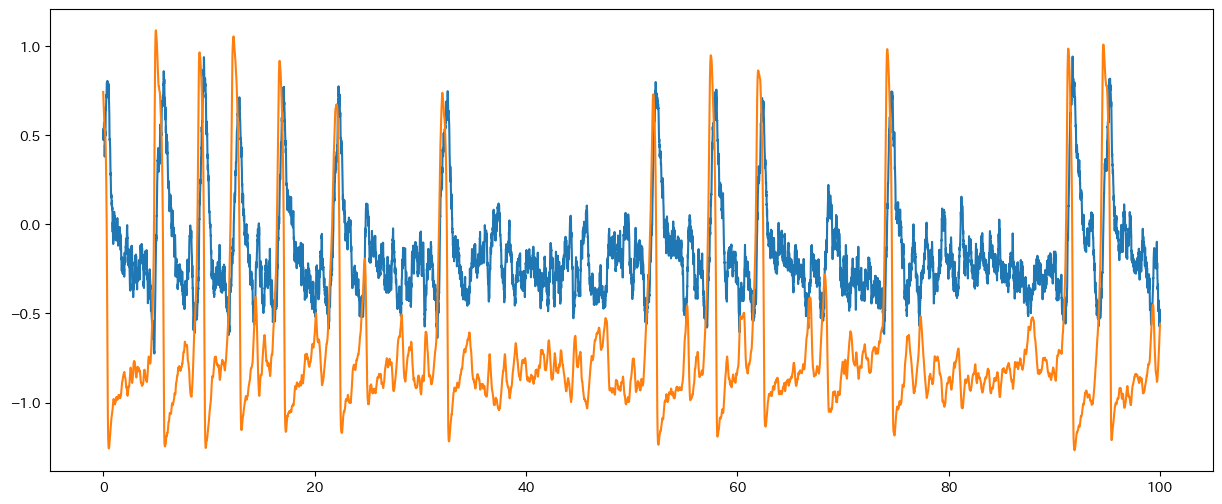

In [101]:
import matplotlib.pyplot as plt
import japanize_matplotlib

time_points = np.linspace(0, 100, int(100 / 0.01) + 1)

plt.figure(figsize=(15, 6))
plt.plot(time_points, x_t[:, 0], label="x")
plt.plot(time_points, y_t[:, 0], label="y")

In [117]:
from dataclasses import dataclass


@dataclass(frozen=True)
class MyClass:
    x: int

    def __post_init__(self):
        object.__setattr__(self, "cache", {})  # frozen でも OK


m = MyClass(10)
# m.cache["a"] = 123  # ✅ OK！

m.cache = {"b": 456}  # ❌ TypeError!
m.x = 99  # ❌ TypeError!

FrozenInstanceError: cannot assign to field 'cache'

In [173]:
from sympy import Array, Symbol

bar_theta_1 = Array([Symbol("bar_theta_10"), Symbol("bar_theta_11")])  # 外部で定義


class Dummy:
    def __init__(self):
        self.bar_theta_1 = Array([Symbol("bar_theta_3")])  # クラス内部で定義


dummy = Dummy()

print(bar_theta_1 == dummy.bar_theta_1)  # ✅ True
print(bar_theta_1 is dummy.bar_theta_1)  # ❌ False

False
False


In [169]:
dummy.bar_theta_1 = Array([Symbol("bar_theta_10")])  # ❌ TypeError!

In [174]:
dummy.bar_theta_1

[bar_theta_3]

In [208]:
from sympy import symbols, Matrix

a, b, c, d = symbols("a b c d")
M = Matrix([[a, b], [c, d]])
M_inv = M.inv()
print(M_inv)

Matrix([[d/(a*d - b*c), -b/(a*d - b*c)], [-c/(a*d - b*c), a/(a*d - b*c)]])


In [209]:
from sympy import Array, Matrix

A = Array([[a, b], [c, d]])
A_mat = Matrix(A)  # ← 変換
A_inv = A_mat.inv()

print(A_inv)

Matrix([[d/(a*d - b*c), -b/(a*d - b*c)], [-c/(a*d - b*c), a/(a*d - b*c)]])


In [210]:
Array(A_inv)

[[d/(a*d - b*c), -b/(a*d - b*c)], [-c/(a*d - b*c), a/(a*d - b*c)]]

In [211]:
from sympy import Array, Symbol

a = Array([1])
x = Symbol("x")

a + x  # ← TypeError: Cannot add Array and Symbol

TypeError: unsupported operand type(s) for +: 'ImmutableDenseNDimArray' and 'Symbol'